# Introduction

Hello there, This analysis notebook aims to answer some questions I find<br>
interesting about the numbers & stats behind popular movies. Wish you find the<br>
results of the analysis intersting & hopefully get a better understanding of the<br>
mainstream movie industry as a whole.


Here are the questions we are answering in this notebook.
- Wordcloud for the description of movie genres
- What are the most popular runtime for movies per year
- What's the most loved movie series that got better

> **NOTE:** the movies used in the analysis are the top 2000 movies in vote count<br>
> on TMDB, in other words the movies here are the **most voted** on TMDB.

# Setting up

In [13]:
import matplotlib.font_manager as fm
import matplotlib.colors as mcolors
import matplotlib.ticker as ticker
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt
import matplotlib as mpl

from scipy.interpolate import interp1d
import seaborn as sns
import pandas as pd
import numpy as np
import itertools
import requests
import datetime
import duckdb
import PIL
import cv2
import os

from wordcloud import (
    get_single_color_func,
    WordCloud,
    STOPWORDS
)

In [2]:
COLORS = ["#080708", "#3772FF", "#DF2935", "#FDCA40", "#c2c2c2"]
FONT_PATH="../fonts/Inter_24pt-Regular.ttf"
FONT = 25
PAD = 25

if os.path.isfile(FONT_PATH):
    fm.fontManager.addfont(FONT_PATH)
    prop = fm.FontProperties(fname=FONT_PATH)
    plt.rcParams['font.family'] = prop.get_name()

In [3]:
df = pd.read_csv("../data/movies_clean.csv")

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2463 entries, 0 to 2462
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Unnamed: 0            2463 non-null   int64  
 1   id                    2463 non-null   int64  
 2   imdb_id               2463 non-null   object 
 3   release_date          2463 non-null   object 
 4   title                 2463 non-null   object 
 5   collection            991 non-null    object 
 6   overview              2463 non-null   object 
 7   tagline               2387 non-null   object 
 8   language              2463 non-null   object 
 9   runtime               2463 non-null   int64  
 10  revenue               2360 non-null   float64
 11  budget                2368 non-null   float64
 12  vote_avg              2463 non-null   float64
 13  vote_count            2463 non-null   int64  
 14  genres                2463 non-null   object 
 15  production_countries 

# The analysis

### **Q1**. Profitable producers

Firstly we should see which production companies have the best budget to revenue and<br>
which have the worst. which have the worst 

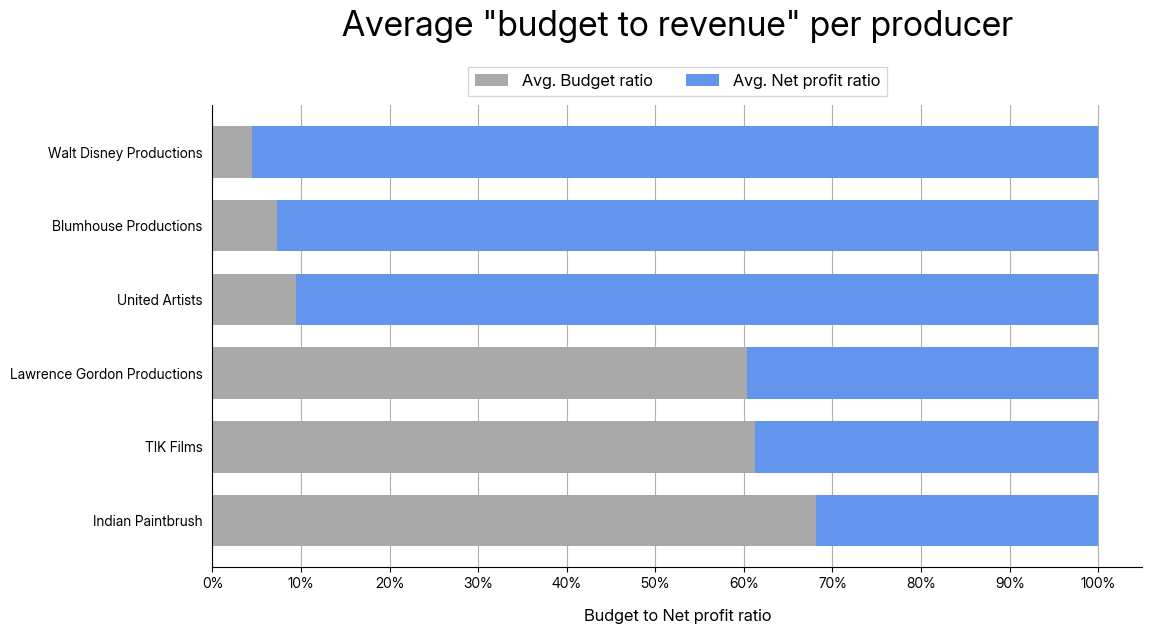

In [4]:
data = duckdb.sql("""
    SELECT producer,
           MEDIAN(budget_to_revenue) AS budget_to_revenue, -- Median is the best for this case
           SUM(occurance) AS occurances,
    FROM (
        SELECT
            UNNEST(SPLIT(production_companies, ', ')) AS producer,
            budget / revenue AS budget_to_revenue,
            1 AS occurance
        FROM df
        WHERE ABS(budget_z_score)  < 3.5 AND -- We don't have to be too strict with outliers
              ABS(revenue_z_score) < 3.5
    )
    GROUP BY producer
    HAVING occurances >= 10 -- Making sure we don't get small producers
    ORDER BY budget_to_revenue DESC -- From most succeful to least succeful
""").df()

data = pd.concat([data.iloc[:3], data.iloc[-3:]])


fig, ax = plt.subplots()

ax.barh(
    data["producer"], data["budget_to_revenue"],
    zorder=2,
    height=0.7,
    color="darkgrey",
    label="Avg. Budget ratio"
)

ax.barh(
    data["producer"], 1-data["budget_to_revenue"],
    left=data["budget_to_revenue"],
    zorder=2,
    height=0.7,
    color="cornflowerblue",
    label="Avg. Net profit ratio" 
)

ax.spines[['right', 'top']].set_visible(False)
ax.grid('off', axis='x', zorder=0)
ax.legend(
    bbox_to_anchor=(0.5, 1.1, 0., 0.), 
    loc="upper center", ncols=2,
    fancybox=False, fontsize=12
) 

ax.set_xticks(np.arange(0, 1.1, 0.1))
ax.yaxis.set_ticks_position('none') 
ax.xaxis.set_major_formatter(
    ticker.FixedFormatter([str(x*10) + "%" for x in range(0, 11)])
)

ax.set_xlabel("Budget to Net profit ratio", fontsize=12, labelpad=13)
ax.set_title("Average \"budget to revenue\" per producer", fontsize=25, pad=50)

fig.set_size_inches(12, 6)
plt.savefig("../imgs/profitable_producer.jpg")
plt.show()

### **Q2**. Profitable genres

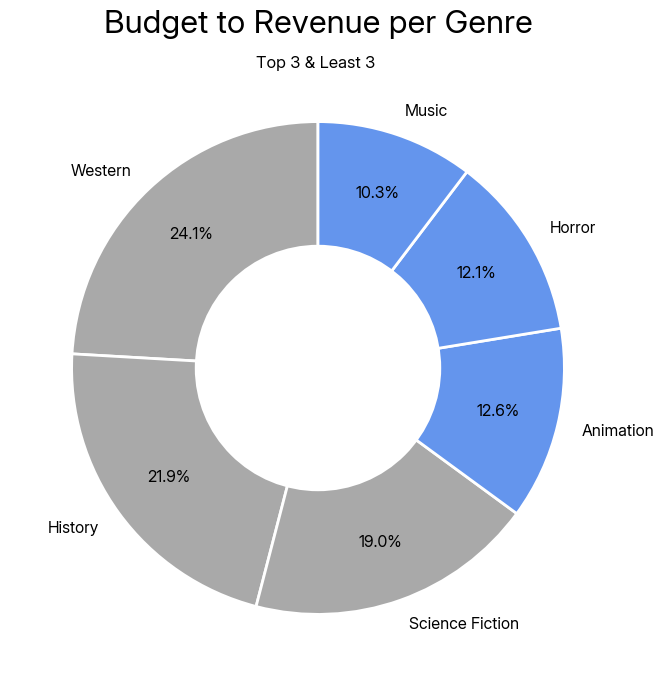

In [5]:
data = duckdb.sql("""
    SELECT genre,
    MEDIAN(budget_to_revenue) AS budget_to_revenue,
    SUM(occurance) AS occurances
    FROM (
        SELECT UNNEST(SPLIT(genres, ', ')) AS genre,
            budget / revenue AS budget_to_revenue,
            1 AS occurance
        FROM df
        WHERE ABS(budget_z_score)  < 3 AND
              ABS(revenue_z_score) < 3
    )
    GROUP BY genre
    HAVING occurances > 20
    ORDER BY budget_to_revenue DESC
""").df()

data = pd.concat([data.iloc[:3], data.iloc[-3:]])

fig, ax = plt.subplots()

colors = ["darkgrey"]*3 + ["cornflowerblue"]*3

ax.pie(
    data["budget_to_revenue"],
    labels=data["genre"],
    autopct='%2.1f%%',
    labeldistance=1.1,
    startangle=90,
    pctdistance=0.75,
    wedgeprops={'edgecolor': 'white', 'linewidth': 2},
    colors=colors,
    textprops={'fontsize':11.5}
)

centre_circle = plt.Circle((0, 0), 0.5, fc='white')
ax.add_artist(centre_circle)

ax.set_title('Budget to Revenue per Genre', fontsize= 23, pad=20)
ax.annotate(xy=(-0.25, 1.22), text='Top 3 & Least 3', fontsize=12)

fig.set_size_inches(10, 8)

plt.show()

### **Q3**. Pobular movies era

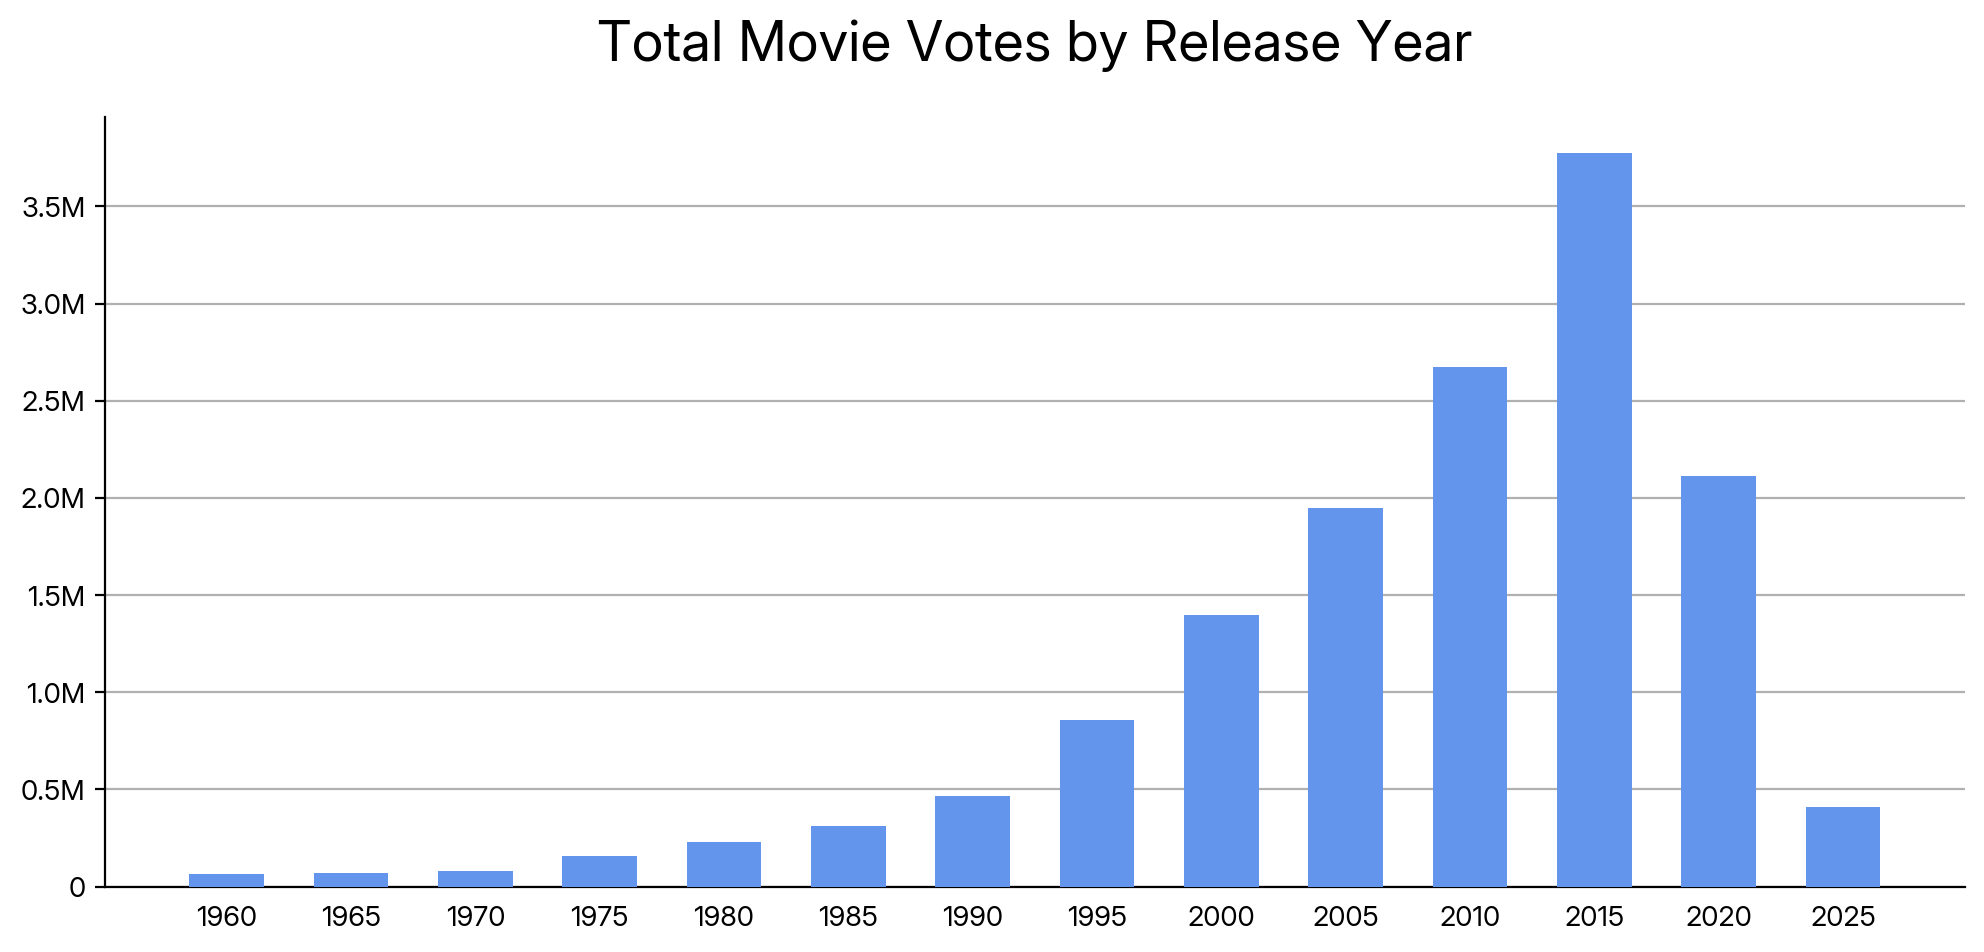

In [6]:
data = duckdb.sql("""
   SELECT 
       SUM(vote_count) AS vote_count,
       COUNT(id) AS occurances,
       ROUND(CAST(SPLIT(release_date, '-')[1] AS INTEGER)/5)*5 AS release_year,
   FROM df
   GROUP BY 
       ROUND(CAST(SPLIT(release_date, '-')[1] AS INTEGER)/5)*5
   HAVING occurances > 10
   ORDER BY release_year ASC
""").df()
# TODO: make the chart smoother

fig, ax = plt.subplots()

ax.bar(
    x=data["release_year"],
    height=data["vote_count"],
    width=3,
    color="cornflowerblue",
    zorder=3
)

spline = interp1d(data["release_year"], data["vote_count"], kind="cubic")
new_x  = np.linspace(
    data["release_year"].min(), data["release_year"].max(), 500
)

# ax.plot(
#     data["release_year"],
#     data["vote_count"],
#     # new_x,
#     # spline(new_x),
#     linewidth=3,
#     color="cornflowerblue",
#     zorder=4
# )
# 
# ax.fill_between(
#     data["release_year"],
#     data["vote_count"],
#     # new_x,
#     # spline(new_x),
#     color="darkgrey",
#     alpha=0.2
# )

ax.set_xticks(data["release_year"], data["release_year"].apply(
    lambda x: f"{x:.0f}"
))
ax.xaxis.set_ticks_position('none') 

ax.spines[['right', 'top']].set_visible(False)
ax.grid('off', axis='y', zorder=0)
ax.yaxis.set_major_formatter(
    lambda x, pos: f"{(x/1_000_000):.1f}M" if x != 0 else 0
)

ax.set_title("Total Movie Votes by Release Year", fontsize=20, pad=20)

fig.set_size_inches(12, 5)
plt.gcf().set_dpi(200) 
plt.show()

###### **Q4**. Genres quality trends

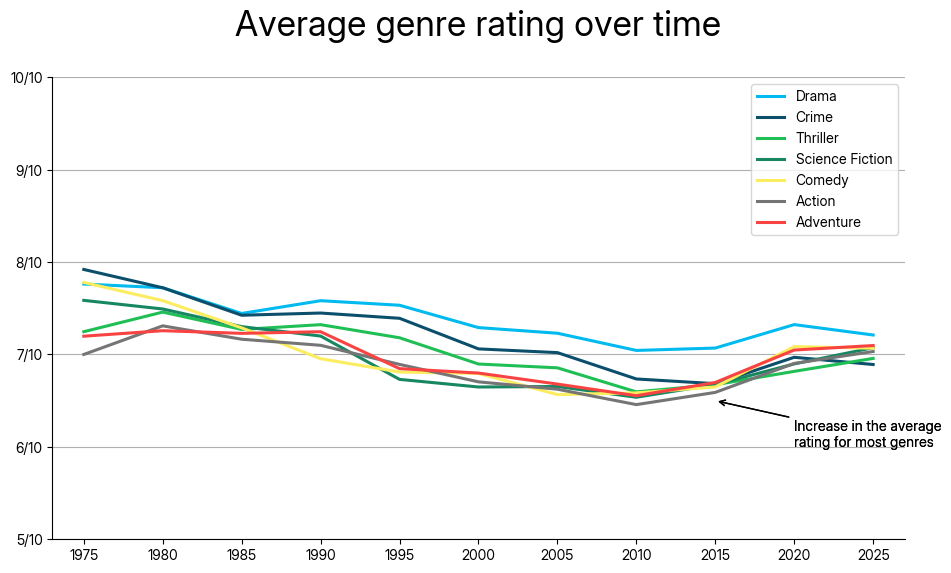

In [7]:
data = duckdb.sql("""
    SELECT
        ROUND(CAST(SPLIT(release_date, '-')[1] AS INTEGER)/5)*5 AS release_year,
        AVG(df.vote_avg) AS vote_avg,
        g1.genre
    FROM df
    
    CROSS JOIN UNNEST(SPLIT(df.genres, ', ')) AS g1(genre)
    
    JOIN (
        SELECT g2.genre
        FROM df
        CROSS JOIN UNNEST(SPLIT(genres, ', ')) AS g2(genre)
        GROUP BY g2.genre
        ORDER BY COUNT(*) DESC
        LIMIT 7
    ) AS common_genres
    
    ON g1.genre = common_genres.genre -- this query was assisted with an LLM
    WHERE release_year > 1970
    GROUP BY release_year, g1.genre
    ORDER BY release_year, vote_avg DESC;
""").df()

fig, ax = plt.subplots()

# HARDCODING the order of the genre so the legend can be more readable
genres = set(data["genre"].unique())

if set(["Comedy", "Crime", "Adventure",
       "Science Fiction", "Drama",
       "Thriller", "Action"]) == genres:
    genres = ["Drama", "Crime", "Thriller", "Science Fiction",
              "Comedy", "Action", "Adventure"]

colors = ["#01BAEF", "#0B4F6C", "#20BF55", "#168761",
          "#FCEC5F", "#757575", "#F94343"]

for i, genre in enumerate(genres):
    genre_data = data.loc[data["genre"] == genre]
    ax.plot(
        genre_data["release_year"],
        genre_data["vote_avg"],
        label=genre,
        linewidth=2.2,
        color=colors[i]
    )

ax.legend()

ax.set_xticks(np.arange(
    data["release_year"].min(),
    data["release_year"].max()+5, 5
))
ax.yaxis.set_major_formatter(
    lambda x, pos: f"{x:.0f}/10"
)

ax.set_xlim(
    xmin=data["release_year"].min() - 2,
    xmax=data["release_year"].max() + 2
)
ax.set_ylim(ymin=5, ymax=10)

ax.spines[["top", "right"]].set_visible(False)
ax.grid("off", axis="y", zorder=0)

ax.annotate(
    "Increase in the average\nrating for most genres",
    xy=(2015, 6.5), xytext=(2020, 6),
    arrowprops=dict(
        arrowstyle="->",
    ))

ax.annotate(
    "Increase in the average\nrating for most genres",
    xy=(2015, 6.5), xytext=(2020, 6),
    arrowprops=dict(
        arrowstyle="->",
    ))

# ax.annotate(
#     "Drama genre has the highest average rating across "
# )

ax.set_title("Average genre rating over time", fontsize=FONT, pad=30)

fig.set_size_inches(11, 6)
plt.show()

### **Q5**. Sequel rating change

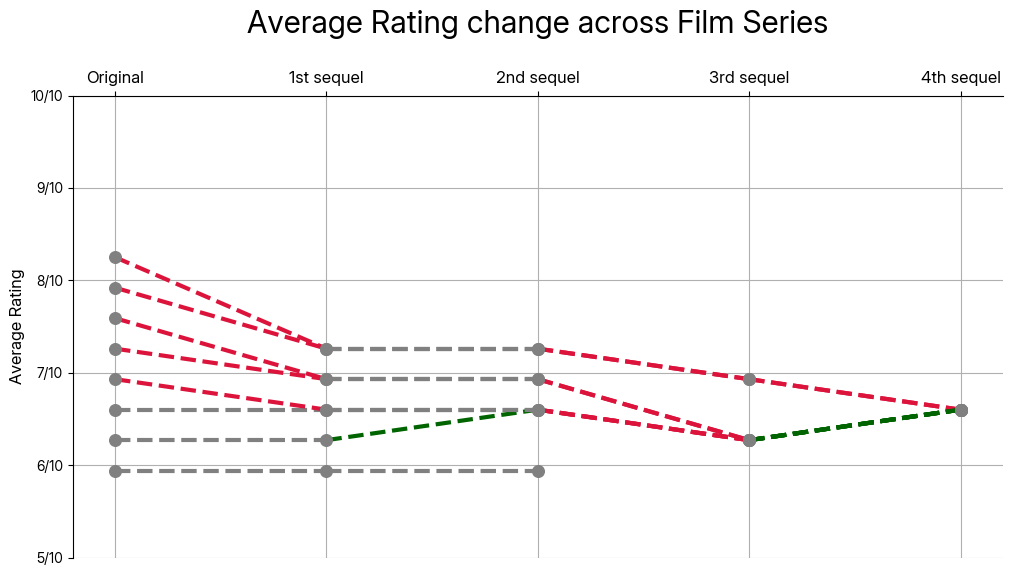

In [45]:
data = duckdb.sql("""
    WITH vote_avgs AS (
        SELECT
            SUM(CASE WHEN seq = 1 THEN vote_avg ELSE NULL END) AS vote_avg_1,
            SUM(CASE WHEN seq = 2 THEN vote_avg ELSE NULL END) AS vote_avg_2,
            SUM(CASE WHEN seq = 3 THEN vote_avg ELSE NULL END) AS vote_avg_3,
            SUM(CASE WHEN seq = 4 THEN vote_avg ELSE NULL END) AS vote_avg_4,
            SUM(CASE WHEN seq = 5 THEN vote_avg ELSE NULL END) AS vote_avg_5,
            COUNT(*) OVER (PARTITION BY vote_avg_1) AS vote_avg_1_freq,
        FROM (
            SELECT 
                collection,
                ROUND(vote_avg / 0.33)* 0.33            AS vote_avg, -- 0.333 would cause rounding errors
                CAST(release_date AS DATE)              AS release_date,
                COUNT(*) OVER (PARTITION BY collection) AS seq_len,
                ROW_NUMBER() OVER (
                    PARTITION BY collection ORDER BY release_date
                )                                       AS seq
            FROM df
        )
        WHERE seq_len > 1
        GROUP BY collection
    ),

    seq_1_vote_avgs AS (
        SELECT
            -- g stands for Grouped
            vote_avg_1 AS vote_avg_1_g,
            COUNT(*) OVER (PARTITION BY vote_avg_1_g) AS vote_occurances,
            ROUND(AVG(vote_avg_2) OVER (PARTITION BY vote_avg_1_g) / 0.33) * 0.33 AS vote_avg_2_g,
            vote_avg_3,
            vote_avg_4,
            vote_avg_5,
        FROM vote_avgs
        WHERE vote_avg_1_freq > 5
    ),

    seq_2_vote_avgs AS (
        SELECT 
            vote_avg_1_g,
            vote_avg_2_g,
            ROUND(AVG(vote_avg_3) OVER (PARTITION BY vote_avg_2_g) / 0.33) * 0.33 AS vote_avg_3_g,
            vote_avg_4,
            vote_avg_5,
        FROM seq_1_vote_avgs
    ),

    seq_3_vote_avgs AS (
        SELECT 
            vote_avg_1_g,
            vote_avg_2_g,
            vote_avg_3_g,
            ROUND(AVG(vote_avg_4) OVER (PARTITION BY vote_avg_3_g) / 0.33) * 0.33 AS vote_avg_4_g,
            vote_avg_5,
        FROM seq_2_vote_avgs
    ),

    final_vote_avgs AS (
        SELECT 
            vote_avg_1_g,
            vote_avg_2_g,
            vote_avg_3_g,
            vote_avg_4_g,
            ROUND(AVG(vote_avg_5) OVER (PARTITION BY vote_avg_4_g) / 0.33) * 0.33 AS vote_avg_5_g,
        FROM seq_3_vote_avgs
    )
    
    SELECT DISTINCT * 
    FROM final_vote_avgs
""").df()

fig, ax = plt.subplots()

for i in range(len(data.columns)):
    for j in range(len(data)):

        ax.scatter(
            i+1, data.iloc[j,i],
            s=70, c="grey", zorder=5
        )
        
        if i == len(data.columns)-1:
            continue

        if   data.iloc[j,i+1] > data.iloc[j,i]: color = "darkgreen"
        elif data.iloc[j,i+1] < data.iloc[j,i]: color = "crimson"
        else:                                   color = "grey"
        
        ax.plot(
            [i+1, i+2], # for formatting purposes
            [data.iloc[j,i], data.iloc[j,i+1]],
            "--", linewidth=3, color=color, zorder=4,
        )

ax.spines[["right", "bottom"]].set_visible(False)
ax.grid("off", axis="x", zorder=-1)
ax.grid("off", axis="y", zorder=-1)
ax.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)

ax.set_xticks(
    np.arange(1, 6),
    ["Original", "1st sequel", "2nd sequel", "3rd sequel", "4th sequel"],
    fontsize=12
)

ax.yaxis.set_major_formatter(
    lambda x, pos: f"{x:.0f}/10"
)
ax.set_ylim(5, 10)
ax.set_title("Average Rating change across Film Series", pad=45, fontsize=22)
ax.set_ylabel("Average Rating", fontsize=12)

fig.set_size_inches(12, 6)
plt.show()

### **Bonus**. Descriptions wordcloud

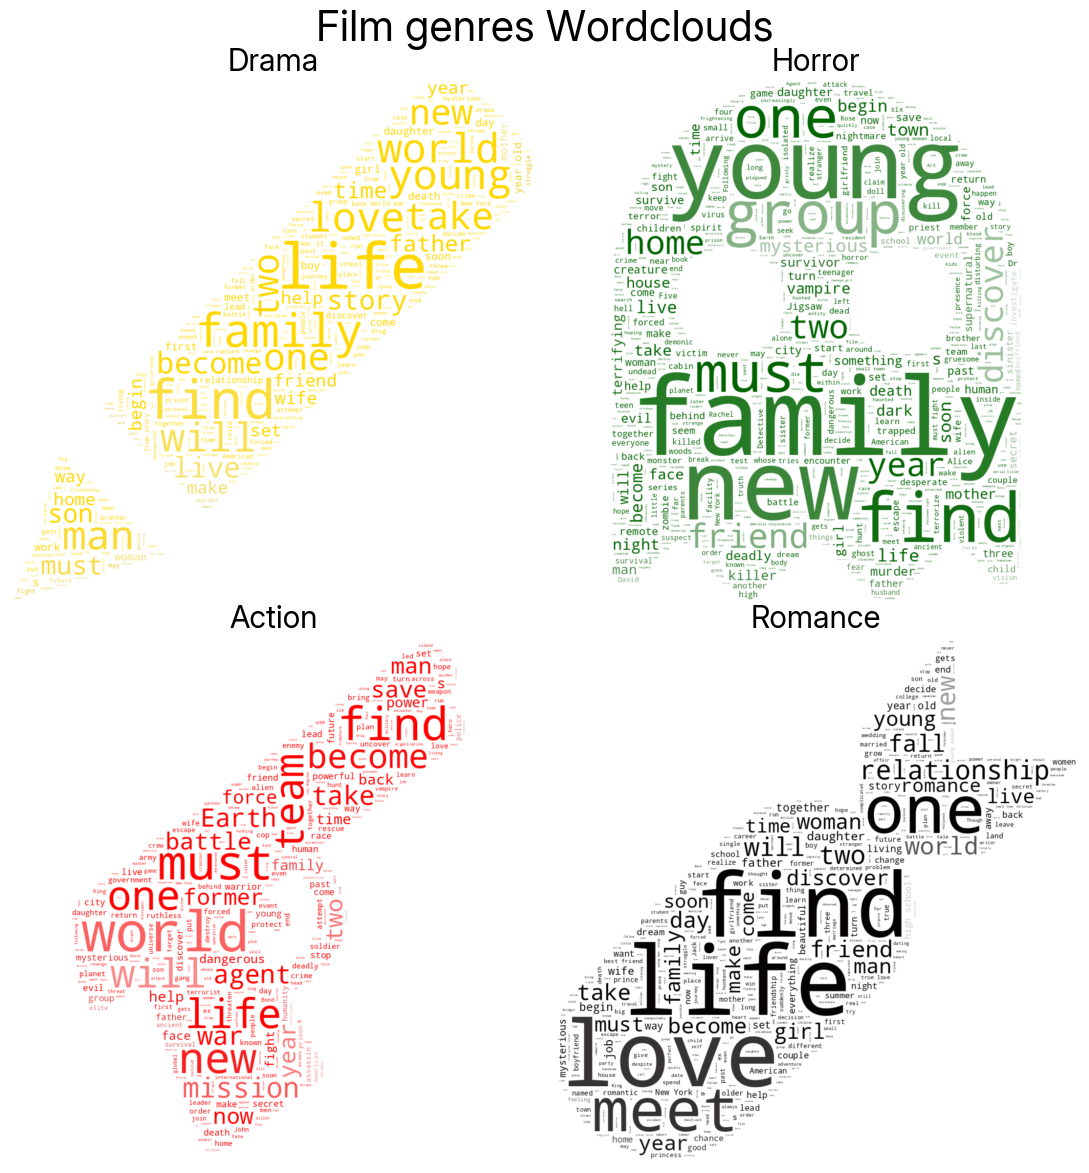

In [89]:
data = duckdb.sql("""
    SELECT genre,
        STRING_AGG(overview, ' ') AS concated_overviews
    FROM (
        SELECT overview, UNNEST(SPLIT(genres, ', ')) AS genre
        FROM df
    )
    WHERE genre IN ('Drama', 'Horror', 'Action', 'Romance')
    GROUP BY genre
    ORDER BY CASE
        WHEN genre = 'Drama' THEN 1
        WHEN genre = 'Horror' THEN 2
        WHEN genre = 'Action' THEN 3
        WHEN genre = 'Romance' THEN 4
    END ASC
""").df()


fig, axes = plt.subplots(nrows=2, ncols=2)
axes = axes.flatten()

mask_paths = [
    "../imgs/assets/pen.png",
    "../imgs/assets/ghost.png",
    "../imgs/assets/gun.png",
    "../imgs/assets/bomb.png",
]

colors = [
    "gold",
    "darkgreen",
    "red",
    "deeppink"
]

for i in range(axes.shape[0]):
    mask_img = cv2.imread(mask_paths[i])
    
    # coloring the mask
    black_pixels = np.all(mask_img == (0, 0, 0), axis=2)
    mask_img[black_pixels] = np.array(mcolors.to_rgb(colors[i]))*255
    mask_img[black_pixels] = np.array(mcolors.to_rgb(colors[i]))*255

    color_func = ImageColorGenerator(mask_img)

    stopwords = set(STOPWORDS)
    stopwords.add("int")
    stopwords.add("ext")

    wc = WordCloud(
        max_words=1000,
        mask=mask_img,
        stopwords=stopwords,
        margin=10,
        random_state=1,
        background_color="white"
    ).generate(data.iloc[i,1])
    
    axes[i].imshow(
        wc.recolor(color_func=color_func),
        interpolation="bilinear"
    )
    axes[i].axis("off")
    axes[i].set_title(f"{data.iloc[i,0]}", fontsize=22)

fig.suptitle("Film genres Wordclouds",fontsize=30)

fig.set_size_inches(11, 12)
plt.tight_layout()

plt.show()

#### **Question 3:**

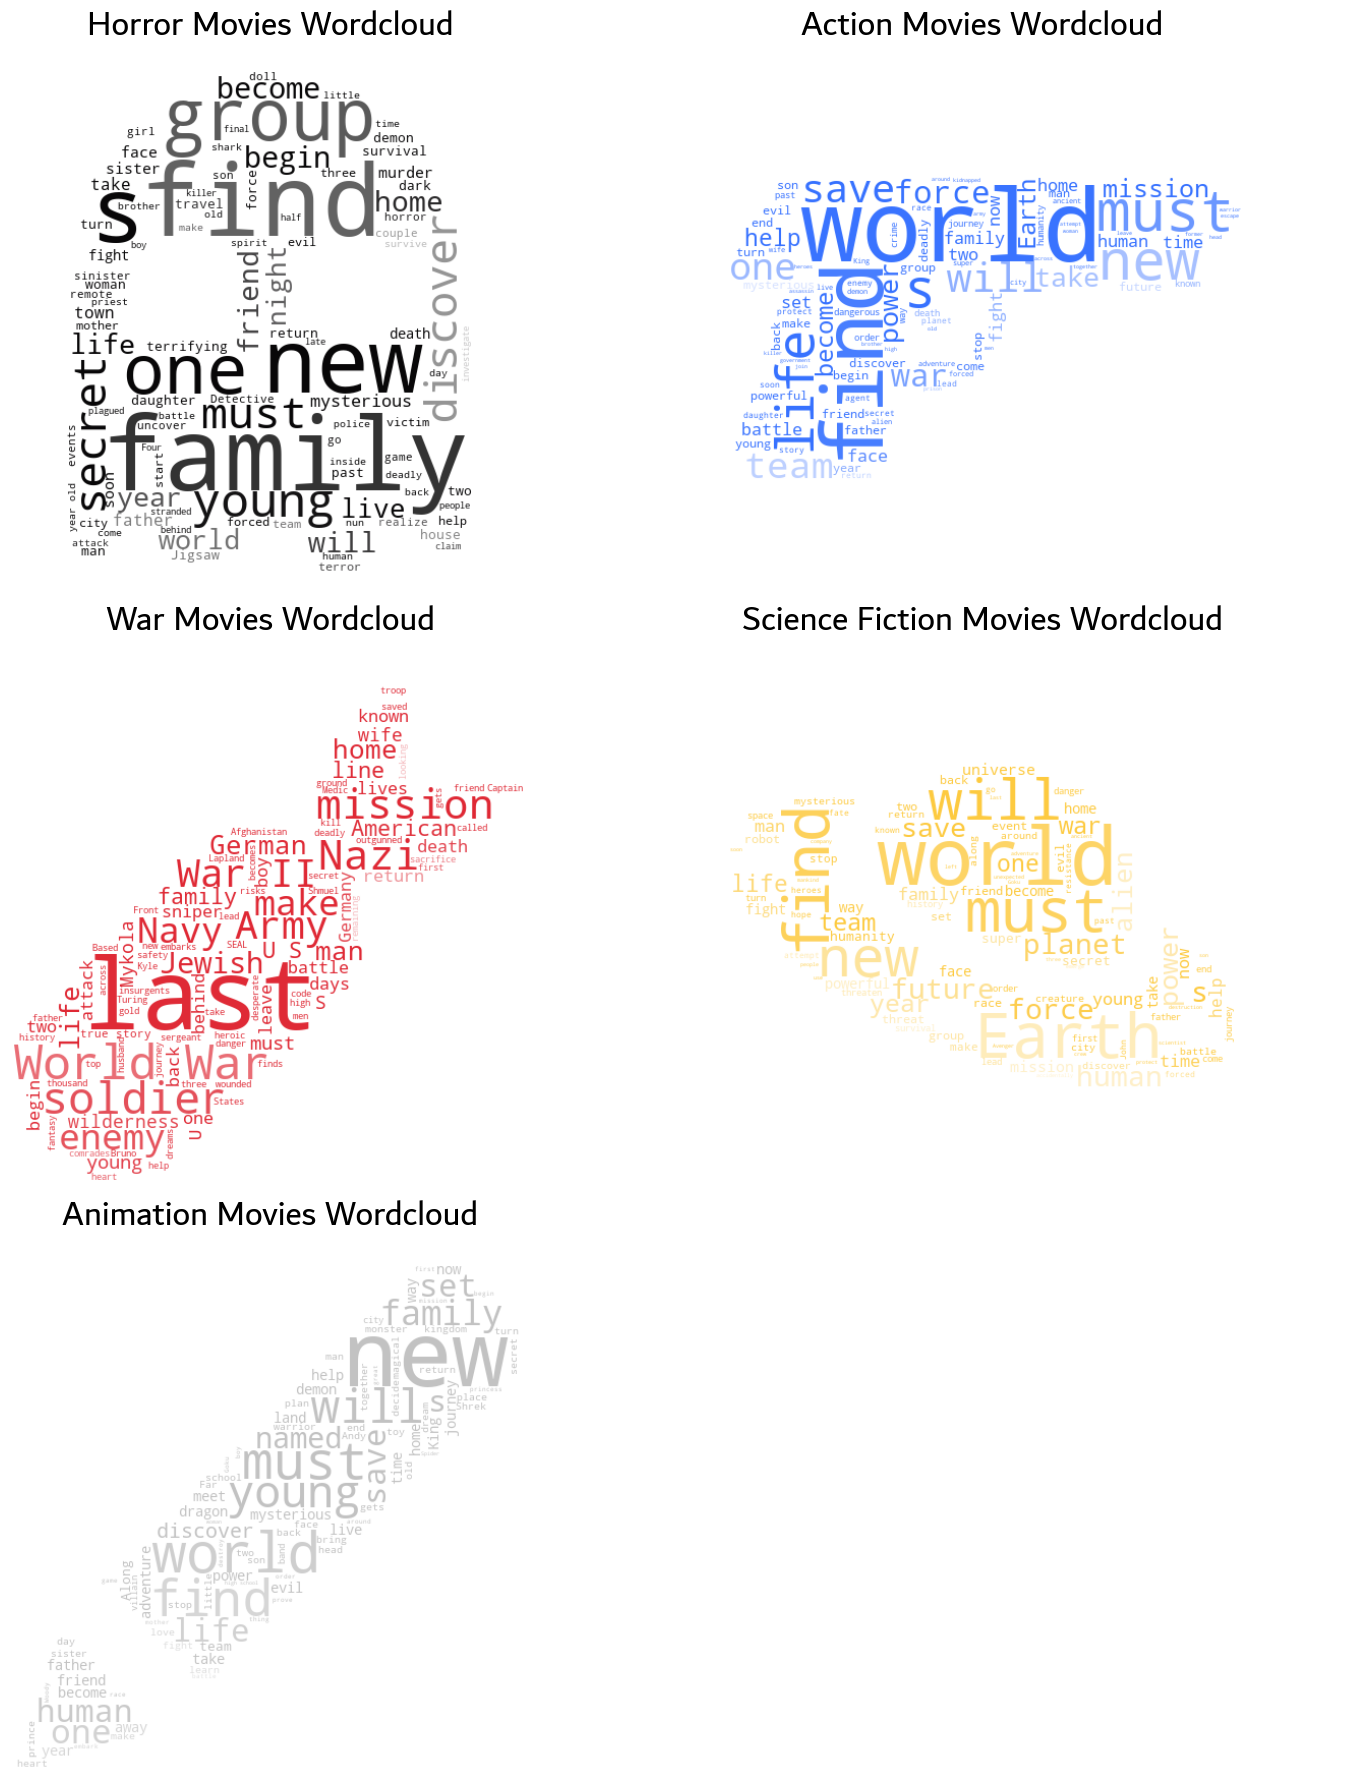

In [315]:
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(nrows=3, ncols=2)

axes = [ax1, ax2, ax3, ax4, ax5, ax6]
mask_paths = ['../imgs/assets/ghost.png',     '../imgs/assets/gun.png',
              '../imgs/assets/bomb.png',       '../imgs/assets/ufo.png',
              '../imgs/assets/pen.png']

top_5_genres = (df_without_outliers[['genres', 'popularity']]
                .explode('genres').groupby('genres', as_index=False)
                .mean().sort_values(by='popularity', ascending=False).head(5))['genres']

for ax, color, genre, mask_path in zip_longest(axes, COLORS, top_5_genres, mask_paths, fillvalue=None):

    if genre is not None:
        
        mask = cv2.imread(mask_path)
        
        hex_color = color.lstrip("#")
        desired_color = [int(hex_color[i:i+2], 16) for i in (0, 2, 4)]

        colormap = np.zeros((256, 1, 3), dtype=np.uint8)

        for i in range(256):
            intensity = i / 255.0
            
            if i < 10:
                colormap[i] = desired_color
            elif i == 255:
                colormap[i] = [255, 255, 255]
            else:
                colormap[i] = [
                    int(desired_color[0] * intensity),
                    int(desired_color[1] * intensity),
                    int(desired_color[2] * intensity)]
            
        mask       = cv2.applyColorMap(mask, colormap)        
        text       = ' '.join(df[df['genres'].apply(lambda l: genre in l)]['overview'])
        color_func = ImageColorGenerator(mask)

        wordcloud = WordCloud(
            background_color= 'white',
            mask=             mask,
            stopwords=        STOPWORDS,
            width=            800,
            height=           800,
            max_words=        100,
            max_font_size= 100).generate(text).recolor(color_func=color_func)

        ax.imshow(wordcloud, interpolation='bilinear')
        ax.set_title(f'{genre} Movies Wordcloud', fontsize= FONT, pad= PAD)

    ax.axis('off')

fig.set_size_inches(15, 18)
plt.tight_layout()

plt.savefig('../plots/movies-genres-wordclouds.png')
plt.show()

# Summary